# Clothes type recognition and classification


> **Demo Project:** In this project we will train clothes classifier that will recognize clothes types (10 categories) from `28x28` pixel images 



## Background

Clothes recognition technology allows you to find the some similar clothes in a short time. At the same time, it can divide different clothes into several common categories to achieve your own classification. For the salers, designers, and Taobao shop owners, The function might be very practical.

In [1]:
# To make debugging of multilayer_perceptron module easier we enable imported modules autoreloading feature.
# By doing this you may change the code of multilayer_perceptron library and all these changes will be available here.
# %load_ext autoreload
# %autoreload 2

# Add project root folder to module loading paths.
import sys
sys.path.append('../..')

### Import Dependencies

In [2]:
# Import 3rd party dependencies.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

# Import custom multilayer perceptron implementation.
from homemade.neural_network import MultilayerPerceptron

### Load the Data

In this demo we will use a sample of [Fashion MNIST dataset in a CSV format](https://www.kaggle.com/zalando-research/fashionmnist) in the kaggle website.


Instead of using full dataset with 60000 training examples we will use cut dataset of just 5000 examples that we will also split into training and testing sets.

Each row in the dataset consists of 785 values: the first value is the label (a category from 0 to 9) and the remaining 784 values (28x28 pixels image) are the pixel values (a number from 0 to 255).

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

In [3]:
# Load the data.
data = pd.read_csv('fashion-mnist-demo.csv')

# Laets create the mapping between numeric category and category name.
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}

# Print the data table.
data.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 29.9 MB


### Plot the Data

Let's peek first 25 rows of the dataset and display them as an images to have an example of clothes we will be working with.

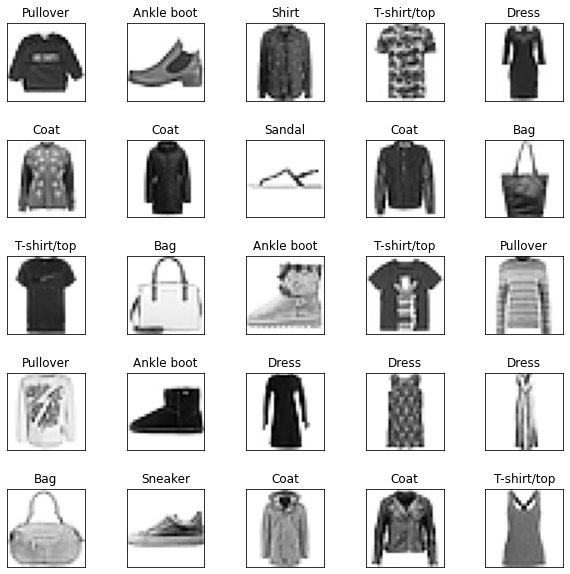

In [5]:
# How many images to display.
numbers_to_display = 25

# Calculate the number of cells that will hold all the images.
num_cells = math.ceil(math.sqrt(numbers_to_display))

# Make the plot a little bit bigger than default one.
plt.figure(figsize=(10, 10))

# Go through the first images in a training set and plot them.
for plot_index in range(numbers_to_display):
    # Extract image data.
    digit = data[plot_index:plot_index + 1].values
    digit_label = digit[0][0]
    digit_pixels = digit[0][1:]

    # Calculate image size (remember that each picture has square proportions).
    image_size = int(math.sqrt(digit_pixels.shape[0]))
    
    # Convert image vector into the matrix of pixels.
    frame = digit_pixels.reshape((image_size, image_size))
    
    # Plot the image matrix.
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(frame, cmap='Greys')
    plt.title(label_map[digit_label])
    plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Plot all subplots.
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

### Split the Data Into Training and Test Sets

In this step we will split our dataset into _training_ and _testing_ subsets (in proportion 80/20%).

Training data set will be used for training of our model. Testing dataset will be used for validating of the model. All data from testing dataset will be new to model and we may check how accurate are model predictions.

In [45]:
# Split data set on training and test sets with proportions 80/20.
# Function sample() returns a random sample of items.
pd_train_data = data.sample(frac=0.8)
pd_test_data = data.drop(pd_train_data.index)

# Convert training and testing data from Pandas to NumPy format.
train_data = pd_train_data.values
test_data = pd_test_data.values

# Extract training/test labels and features.

x_train = train_data[:, 1:]
y_train = train_data[:, [0]]

x_test = test_data[:, 1:]
y_test = test_data[:, [0]]

### Init and Train MLP Model
  
A **multilayer perceptron (MLP)** is a class of feedforward artificial neural network. An MLP consists of, at least, three layers of nodes: an input layer, a hidden layer and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training. Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable.

- `layers` - configuration of the multilayer perceptron layers (array of numbers where every number represents the number of nayron in specific layer).
- `max_iterations` - this is the maximum number of iterations that gradient descent algorithm will use to find the minimum of a cost function. Low numbers may prevent gradient descent from reaching the minimum. High numbers will make the algorithm work longer without improving its accuracy.
- `regularization_param` - parameter that will fight overfitting. The higher the parameter, the simplier is the model will be.
- `normalize_data` - boolean flag that indicates whether data normalization is needed or not.
- `alpha` - the size of gradient descent steps. You may need to reduce the step size if gradient descent can't find the cost function minimum. 

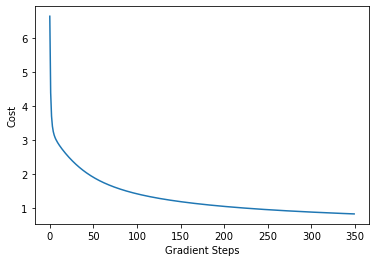

In [7]:
# Configure neural network.
layers = [
    784, # Input layer - 28x28 input pixels.
    25,  # First hidden layer - 25 hidden units.
    10,  # Output layer - 10 labels, from 0 to 9.
];
normalize_data = True  # Flag that detects whether we want to do features normalization or not.
epsilon = 0.12  # Defines the range for initial theta values.
max_iterations = 350  # Max number of gradient descent iterations.
regularization_param = 2  # Helps to fight model overfitting.
alpha = 0.1  # Gradient descent step size.

# Init neural network.
multilayer_perceptron = MultilayerPerceptron(x_train, y_train, layers, epsilon, normalize_data)

# Train neural network.
(thetas, costs) = multilayer_perceptron.train(regularization_param, max_iterations, alpha)

plt.plot(range(len(costs)), costs)
plt.xlabel('Gradient Steps')
plt.ylabel('Cost')
plt.show()

### Calculate Model Training Precision

Calculate how many of training and test examples have been classified correctly. Normally we need test precission to be as high as possible. In case if training precision is high and test precission is low it may mean that our model is overfitted (it works really well with the training data set but it is not good at classifying new unknown data from the test dataset). In this case you may want to play with `regularization_param` parameter to fighth the overfitting.

In [8]:
# Make training set predictions.
y_train_predictions = multilayer_perceptron.predict(x_train)
y_test_predictions = multilayer_perceptron.predict(x_test)

# Check what percentage of them are actually correct.
train_precision = np.sum(y_train_predictions == y_train) / y_train.shape[0] * 100
test_precision = np.sum(y_test_predictions == y_test) / y_test.shape[0] * 100

print('Training Precision: {:5.4f}%'.format(train_precision))
print('Test Precision: {:5.4f}%'.format(test_precision))

Training Precision: 87.0750%
Test Precision: 80.9000%


In [9]:
from sklearn import metrics
print('\n>>>confusion matrix\n', metrics.confusion_matrix(y_test, y_test_predictions))
print('\n>>>classification report\n', metrics.classification_report(y_test, y_test_predictions))
# print("\n>>>ROC_AUC Score (Train): %f\n" % metrics.roc_auc_score(y_test, y_test_predictions))


>>>confusion matrix
 [[83  0  2  6  2  1  3  0  0  0]
 [ 0 87  0  0  0  0  0  0  0  0]
 [ 1  1 67  0  9  2  6  0  0  0]
 [ 4  3  0 96  5  0  4  0  0  0]
 [ 0  0 11  3 78  0 11  0  0  0]
 [ 0  0  0  0  0 95  0 10  0  2]
 [24  1 23  3 17  0 44  0  5  0]
 [ 0  0  0  0  0  5  0 91  0  8]
 [ 1  0  2  2  1  1  3  3 89  0]
 [ 0  0  0  0  0  0  0  6  0 79]]

>>>classification report
               precision    recall  f1-score   support

           0       0.73      0.86      0.79        97
           1       0.95      1.00      0.97        87
           2       0.64      0.78      0.70        86
           3       0.87      0.86      0.86       112
           4       0.70      0.76      0.73       103
           5       0.91      0.89      0.90       107
           6       0.62      0.38      0.47       117
           7       0.83      0.88      0.85       104
           8       0.95      0.87      0.91       102
           9       0.89      0.93      0.91        85

    accuracy            

In [10]:
storage=[]
storage.append(train_precision)
storage.append(test_precision)

### Init and Train Logistic Regression Model



- `polynomial_degree` - this parameter will allow you to add additional polynomial features of certain degree. More features - more curved the line will be.
- `max_iterations` - this is the maximum number of iterations that gradient descent algorithm will use to find the minimum of a cost function. Low numbers may prevent gradient descent from reaching the minimum. High numbers will make the algorithm work longer without improving its accuracy.
- `regularization_param` - parameter that will fight overfitting. The higher the parameter, the simplier is the model will be.
- `polynomial_degree` - the degree of additional polynomial features (`x1^2 * x2, x1^2 * x2^2, ...`). This will allow you to curve the predictions.
- `sinusoid_degree` - the degree of sinusoid parameter multipliers of additional features (`sin(x), sin(2*x), ...`). This will allow you to curve the predictions by adding sinusoidal component to the prediction curve.
- `normalize_data` - boolean flag that indicates whether data normalization is needed or not.

In [11]:
# Import custom logistic regression implementation.
from homemade.logistic_regression import LogisticRegression

In [12]:
# Set up linear regression parameters.
max_iterations = 5000  # Max number of gradient descent iterations.
regularization_param = 25  # Helps to fight model overfitting.
polynomial_degree = 0  # The degree of additional polynomial features.
sinusoid_degree = 0  # The degree of sinusoid parameter multipliers of additional features.
normalize_data = True  # Whether we need to normalize data to make it more unifrom or not. 

# Init logistic regression instance.
logistic_regression = LogisticRegression(x_train, y_train, polynomial_degree, sinusoid_degree, normalize_data)

# Train logistic regression.
(thetas, costs) = logistic_regression.train(regularization_param, max_iterations)

### Analyze Gradient Descent Progress

The plot below illustrates how the cost function value changes over each iteration. You should see it decreasing. 

In case if cost function value increases it may mean that gradient descent missed the cost function minimum and with each step it goes further away from it.

From this plot you may also get an understanding of how many iterations you need to get an optimal value of the cost function.

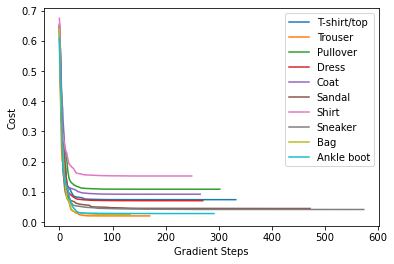

In [13]:
# Draw gradient descent progress for each label.
labels = logistic_regression.unique_labels
for index, label in enumerate(labels):
    plt.plot(range(len(costs[index])), costs[index], label=label_map[labels[index]])

plt.xlabel('Gradient Steps')
plt.ylabel('Cost')
plt.legend()
plt.show()

### Calculate Model Training Precision

Calculate how many of training and test examples have been classified correctly. Normally we need test precission to be as high as possible. In case if training precision is high and test precission is low it may mean that our model is overfitted (it works really well with the training data set but it is not good at classifying new unknown data from the test dataset). In this case you may want to play with `regularization_param` parameter to fighth the overfitting.

In [14]:
# Make training set predictions.
y_train_predictions = logistic_regression.predict(x_train)
y_test_predictions = logistic_regression.predict(x_test)

# Check what percentage of them are actually correct.
train_precision = np.sum(y_train_predictions == y_train) / y_train.shape[0] * 100
test_precision = np.sum(y_test_predictions == y_test) / y_test.shape[0] * 100

print('Training Precision: {:5.4f}%'.format(train_precision))
print('Test Precision: {:5.4f}%'.format(test_precision))

Training Precision: 92.9000%
Test Precision: 83.4000%


In [15]:
storage.append(train_precision)
storage.append(test_precision)

## SVM

In [16]:
from sklearn import svm

In [17]:
clf = svm.SVC(decision_function_shape='ovr')
clf.fit(x_train, y_train.ravel())

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [18]:
train_precision = clf.score(x_train, y_train)
test_precision = clf.score(x_test, y_test)

print('Training Precision: {:5.4f}%'.format(train_precision))
print('Test Precision: {:5.4f}%'.format(test_precision))

Training Precision: 0.8910%
Test Precision: 0.8330%


In [19]:
storage.append(train_precision)
storage.append(test_precision)

## Random tree

In [20]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
# your implementation here...

# random forest tree model 
# kfold = model_selection.KFold(n_splits=10)
random_clf = RandomForestClassifier(n_estimators=200)

random_clf.fit(x_train, y_train.ravel())
train_acc = model_selection.cross_val_score(random_clf, x_train, y_train.ravel(), cv=10, scoring='accuracy')
test_acc = model_selection.cross_val_score(random_clf, x_train, y_train.ravel(), cv=10, scoring='accuracy')

In [21]:
print('Training Precision: {:5.4f}%'.format(train_acc.mean()))
print('Test Precision: {:5.4f}%'.format(test_acc.mean()))

Training Precision: 0.8453%
Test Precision: 0.8438%


In [22]:
storage.append(train_acc.mean())
storage.append(test_acc.mean())

## CNN model

In [38]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras import backend as K

In [46]:
num_classes = 10
batch_size = 128
epochs = 20

In [47]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [48]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)              

In [49]:
def extend_channel(data):
    if K.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, 28, 28)
    else:
        data = data.reshape(data.shape[0], 28, 28, 1)
        
    return data

x_train = extend_channel(x_train)
x_test = extend_channel(x_test)

input_shape = x_train.shape[1:]

In [50]:
y_train2 = keras.utils.to_categorical(y_train, num_classes)
y_test2 = keras.utils.to_categorical(y_test, num_classes)

x_train = extend_channel(x_train)

In [51]:
#model.fit()
x_train = extend_channel(x_train)
result = model.fit(x_train, y_train2,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test2))

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 2s 479us/step - loss: 8.0935 - accuracy: 0.4597 - val_loss: 0.7380 - val_accuracy: 0.7370
Epoch 2/20
4000/4000 [==============================] - 2s 409us/step - loss: 1.0567 - accuracy: 0.6260 - val_loss: 0.6301 - val_accuracy: 0.7630
Epoch 3/20
4000/4000 [==============================] - 2s 409us/step - loss: 0.8900 - accuracy: 0.6942 - val_loss: 0.5925 - val_accuracy: 0.7620
Epoch 4/20
4000/4000 [==============================] - 2s 415us/step - loss: 0.7745 - accuracy: 0.7293 - val_loss: 0.6459 - val_accuracy: 0.7810
Epoch 5/20
4000/4000 [==============================] - 2s 405us/step - loss: 0.6879 - accuracy: 0.7452 - val_loss: 0.4814 - val_accuracy: 0.8240
Epoch 6/20
4000/4000 [==============================] - 2s 404us/step - loss: 0.6048 - accuracy: 0.7805 - val_loss: 0.4222 - val_accuracy: 0.8460
Epoch 7/20
4000/4000 [==============================] - 2s 401us/step - loss

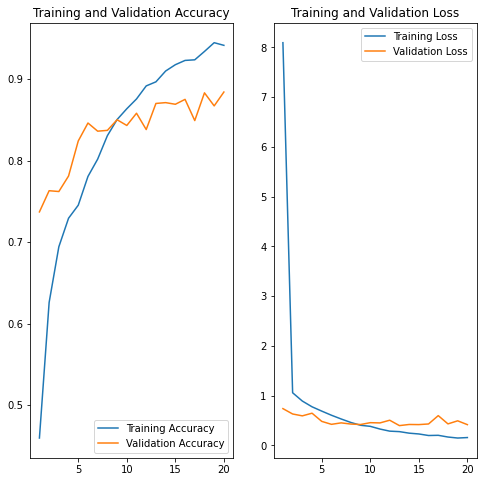

In [52]:
epochs_range = range(1,21)
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']
loss = result.history['loss']
val_loss = result.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
score = model.evaluate(x_train, y_train2, verbose=1)
score1 = model.evaluate(x_test, y_test2, verbose=1)

print('train Precision: {:5.4f}%'.format(score[1]))
print('Test Precision: {:5.4f}%'.format(score1[1]))

1000/1000 [==============================] - 0s 198us/step
train Precision: 0.9898%
Test Precision: 0.8840%


In [54]:
storage.append(score[1])
storage.append(score1[1])

## Summary

From this project, we use MLP, logistic regression, SVM, random forest tree and cNN to do clafficiation

In [56]:
import pandas as pd
tmp={'MLP':[storage[0],storage[1]],
     'Logistic regression':[storage[2],storage[3]],
     'SVM':[storage[4],storage[5]],
     'Random Forest':[storage[6],storage[7]],
     'cNN':[storage[8],storage[9]]}
table=pd.DataFrame(tmp,columns=['MLP','Logistic regression','SVM','Random Forest','cNN'],
                  index=['Train Precision','Test Precision'])
table

,MLP,Logistic regression,SVM,Random Forest,cNN
Train Precision,87.075,92.9,0.891,0.84525,0.98975
Test Precision,80.900,83.4,0.833,0.84375,0.88400


The test precision is not very high  
I think one reason is maybe the training set is a little small, the original data set has 60000 data, but I only take 5000 data to train it.  the second reason might be some clothes type is similar.  
In this five model, the cNN proformance is the best, the test precision could be 0.868, and the other four classification is nearly 0.83. 

## Training full dataset in CNN model

In [34]:
newdata = pd.read_csv('fashion-mnist_train.csv')

In [35]:
# Split data set on training and test sets with proportions 80/20.
# Function sample() returns a random sample of items.
pd_train_data = newdata.sample(frac=0.8)
pd_test_data = newdata.drop(pd_train_data.index)

# Convert training and testing data from Pandas to NumPy format.
train_data = pd_train_data.values
test_data = pd_test_data.values

# Extract training/test labels and features.

x_train = train_data[:, 1:]
y_train = train_data[:, [0]]

x_test = test_data[:, 1:]
y_test = test_data[:, [0]]

In [36]:
def extend_channel(data):
    if K.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, 28, 28)
    else:
        data = data.reshape(data.shape[0], 28, 28, 1)
        
    return data

x_train = extend_channel(x_train)
x_test = extend_channel(x_test)

input_shape = x_train.shape[1:]
num_classes = 10
batch_size = 128
epochs = 20

In [37]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
y_train2 = keras.utils.to_categorical(y_train, num_classes)
y_test2 = keras.utils.to_categorical(y_test, num_classes)

x_train = extend_channel(x_train)
result = model.fit(x_train, y_train2,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test2))

score = model.evaluate(x_train, y_train2, verbose=1)
score1 = model.evaluate(x_test, y_test2, verbose=1)

print('train Precision: {:5.4f}%'.format(score[1]))
print('Test Precision: {:5.4f}%'.format(score1[1]))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 20s 413us/step - loss: 1.4090 - accuracy: 0.7371 - val_loss: 0.4026 - val_accuracy: 0.8510
Epoch 2/20
48000/48000 [==============================] - 20s 413us/step - loss: 0.4239 - accuracy: 0.8508 - val_loss: 0.3377 - val_accuracy: 0.8844
Epoch 3/20
48000/48000 [==============================] - 20s 416us/step - loss: 0.3516 - accuracy: 0.8777 - val_loss: 0.2997 - val_accuracy: 0.8919
Epoch 4/20
48000/48000 [==============================] - 20s 421us/step - loss: 0.3108 - accuracy: 0.8913 - val_loss: 0.2733 - val_accuracy: 0.9042
Epoch 5/20
48000/48000 [==============================] - 20s 420us/step - loss: 0.2786 - accuracy: 0.9001 - val_loss: 0.2932 - val_accuracy: 0.9048
Epoch 6/20
48000/48000 [==============================] - 20s 416us/step - loss: 0.2602 - accuracy: 0.9079 - val_loss: 0.2661 - val_accuracy: 0.9105
Epoch 7/20
48000/48000 [==============================] 